<a href="https://colab.research.google.com/github/mdrk300902/mdrk300902/blob/main/mistral_7b_qlora_alpaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **mistral-7b-qlora-alpaca**
This project presents a practical demonstration of instruction‑tuning the Mistral‑7B large language model using QLoRA, a parameter‑efficient fine‑tuning method. By employing 4‑bit quantization, the model can be trained on hardware with limited memory capacity, such as the free Google Colab T4 GPU.

The primary objectives are as follows:


1.   Showcase a complete, reproducible workflow for adapting a large‑scale model in a resource‑constrained environment.

2.   Utilise a small, curated subset of the Alpaca instruction‑following dataset to illustrate the fine‑tuning process from start to finish.

3.  Highlight practical skills in data preparation, model optimisation, and deployment‑ready output generation.






**The notebook Demonstrates:**

* The use of quantisation techniques to load and operate 7‑billion‑parameter
models efficiently.

* Application of QLoRA via the PEFT framework to update only targeted layers, thereby reducing computational cost.

* Integration of Hugging Face’s Trainer API for supervised fine‑tuning with intermediate evaluation and logging.

* Best practices for saving LoRA adapters separately, ensuring that the fine‑tuned model remains lightweight and portable for future inference.

Check Available GPU Hardware

In [ ]:
!nvidia-smi || echo "No NVIDIA GPU detected; this may run on CPU and be very slow."

Fri Aug 15 07:23:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Manage Dependencies and Install Specific Package Versions

In [ ]:
!pip uninstall -y torch torchvision torchaudio triton bitsandbytes transformers accelerate peft numpy
!pip install numpy==1.26.4
!pip install --index-url https://download.pytorch.org/whl/cu121 torch==2.3.1 torchvision torchaudio
!pip install triton==2.3.1 bitsandbytes==0.43.1
!pip install transformers==4.43.3 peft==0.11.1 accelerate==0.32.1 datasets

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
sentence-transformers 5.1.0 requires torch>=1.11.0, which is not installed.
sentence-transformers 5.1.0 requires transformers<5.0.0,>=4.41.0, which is not installed.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but 

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

Manage Imports and Verify PyTorch and CUDA Installation

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.3.1+cu121 CUDA: 12.1
CUDA available: True


Load the Alpaca Instruction-Following Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("tatsu-lab/alpaca")

Install dependencies (Transformers, Datasets, PEFT, Accelerate, BitsAndBytes)

In [ ]:
!pip -q install --upgrade pip
!pip -q install "transformers>=4.41.0" "datasets>=2.18.0" "peft>=0.11.0" "accelerate>=0.30.0" bitsandbytes==0.43.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.3 MB/s eta 0:00:00


Imports & Config

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, PeftModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Model & training parameters/knobs
model_id = "mistralai/Mistral-7B-v0.1"  # could be switched to newer Mistral if available
max_length = 512
train_samples = 200
eval_samples = 60
max_steps = 60
grad_accum = 4
per_device_bs = 1
lr = 2e-4

Using device: cuda


Load Alpaca dataset and sample a small subset

In [ ]:
dataset = load_dataset("tatsu-lab/alpaca")

# Shuffling and selecting small subsets for train/eval to fit free GPU constraints
train_dataset = dataset["train"].shuffle(seed=42).select(range(train_samples))
eval_dataset  = dataset["train"].shuffle(seed=123).select(range(eval_samples))

# Peeking
train_dataset[0]

{'instruction': 'What would be the best type of exercise for a person who has arthritis?',
 'input': '',
 'output': 'For someone with arthritis, the best type of exercise would be low-impact activities like yoga, swimming, or walking. These exercises provide the benefits of exercise without exacerbating the symptoms of arthritis.',
 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat would be the best type of exercise for a person who has arthritis?\n\n### Response:\nFor someone with arthritis, the best type of exercise would be low-impact activities like yoga, swimming, or walking. These exercises provide the benefits of exercise without exacerbating the symptoms of arthritis.'}

Authenticate with Hugging Face

In [ ]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `token1` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.ca

Build prompt template + tokenize

In [ ]:
# Alpaca has fields: instruction, input, output
def build_prompt(example):
    instr = example.get("instruction", "").strip()
    inp   = example.get("input", "").strip()
    out   = example.get("output", "").strip()

    if inp:
        user = f"### Instruction:\n{instr}\n\n### Input:\n{inp}"
    else:
        user = f"### Instruction:\n{instr}"
    assistant = f"\n\n### Response:\n{out}"
    return user + assistant

from functools import partial

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
# Mistral-like models: use EOS as pad
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

def tokenize(example, tokenizer, max_length=512):
    text = build_prompt(example)
    toks = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    # For causal LM with Trainer, labels = input_ids
    toks["labels"] = toks["input_ids"].copy()
    return toks

tokenized_train = train_dataset.map(partial(tokenize, tokenizer=tokenizer, max_length=max_length), batched=False)
tokenized_eval  = eval_dataset.map(partial(tokenize, tokenizer=tokenizer, max_length=max_length), batched=False)

len(tokenized_train), len(tokenized_eval)


Load Mistral-7B in 4-bit & apply QLoRA

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Typical LoRA on LLaMA/Mistral-style attention (q_proj, v_proj)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
  )

model = get_peft_model(model, lora_config)

In [ ]:
model.print_trainable_parameters()

trainable params: 6,815,744 || all params: 7,248,547,840 || trainable%: 0.0940


Data collator for causal LM

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

 Train (suitable for free Colab)

In [ ]:
output_dir = "./mistral-7b-qlora-alpaca"
logging_steps = 5

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_bs,
    per_device_eval_batch_size=per_device_bs,
    gradient_accumulation_steps=grad_accum,
    learning_rate=lr,
    max_steps=max_steps,                 # keeping low for demo;  could be increased if access to better GPUs for better results
    warmup_steps=max(2, max_steps//10),
    lr_scheduler_type="cosine",
    fp16=(torch.cuda.is_available() and torch.cuda.get_device_capability()[0] < 8),
    bf16=(torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8),
    logging_steps=logging_steps,
    evaluation_strategy="steps",
    eval_steps=logging_steps*2,
    save_strategy="no",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

train_result = trainer.train()
train_result.metrics

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
10,1.560700,1.372365
20,1.181600,1.254735
30,1.276000,1.165920
40,1.146800,1.151133
50,1.105200,1.145649
60,1.067200,1.144474


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


{'train_runtime': 477.122,
 'train_samples_per_second': 0.503,
 'train_steps_per_second': 0.126,
 'total_flos': 5247572587315200.0,
 'train_loss': 1.2770819664001465,
 'epoch': 1.2}

  Quick generation test

In [ ]:
model.eval()
prompt = "### Instruction:\nExplain the concept of overfitting in machine learning.\n\n### Response:\n"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        temperature=0.7,
        top_p=0.9,
        do_sample=True
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Instruction:
Explain the concept of overfitting in machine learning.

### Response:
Overfitting is a common problem in machine learning, and it occurs when a model learns too much from the training data and is not able to generalize well to new data. This can lead to poor performance on new data, even though the model performed well on the training data. To prevent overfitting, models need to be trained on a wide range of data and have the ability to generalize to new data. This can be achieved through regularization, which helps to reduce the complexity of the model and prevents it from overfitting.


 Save LoRA adapters (recommended for QLoRA)

In [ ]:
adapters_dir = "./mistral-7b-qlora-alpaca-adapters"
model.save_pretrained(adapters_dir)
tokenizer.save_pretrained(adapters_dir)
print("Saved LoRA adapters to:", adapters_dir)

Saved LoRA adapters to: ./mistral-7b-qlora-alpaca-adapters


Losses Plotting (Traning & Validation)

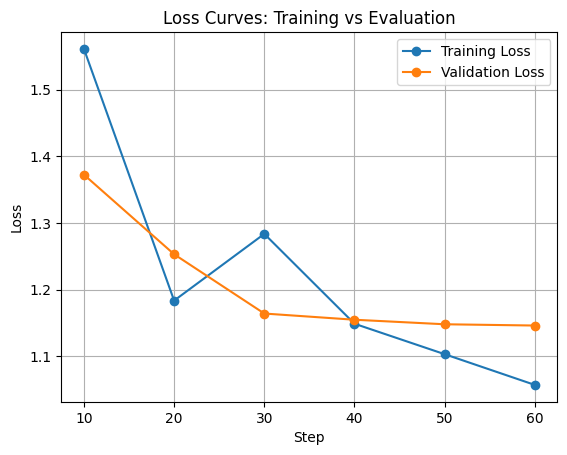

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_metrics["step"], df_metrics["train_loss"], label="Training Loss", marker="o")
plt.plot(df_metrics["step"], df_metrics["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Curves: Training vs Evaluation")
plt.legend()
plt.grid(True)
plt.show()

Generating Sample

In [ ]:
# Example prompts for testing
test_prompts = [
    "Explain overfitting in machine learning.",
    "List three benefits of unit testing.",
    "What is regularization and why is it useful?",
]

for prompt in test_prompts:
    inputs = tokenizer(f"### Instruction:\n{prompt}\n\n### Response:\n", return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    print(f"Prompt: {prompt}\nResponse: {tokenizer.decode(outputs[0], skip_special_tokens=True)}\n{'-'*40}")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: Explain overfitting in machine learning.
Response: ### Instruction:
Explain overfitting in machine learning.

### Response:
Overfitting is a phenomenon that occurs when a model is too complex for the data it is trained on. As a result, the model starts to learn the noise in the data instead of the underlying structure. This can lead to a model that performs well on training data but poorly on test data. To prevent overfitting, machine learning algorithms use regularization techniques such as weight decay and dropout. These techniques help to reduce the complexity of the model, preventing it from overfitting on the training data.
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: List three benefits of unit testing.
Response: ### Instruction:
List three benefits of unit testing.

### Response:
Unit testing helps to identify and fix bugs before they reach the user, ensures code is well-written and easy to maintain, and provides a foundation for future development.
Unit testing is a process of testing small units of code to ensure they are working correctly. It is a fundamental part of software development and is used to identify and fix bugs, ensure code is well-written and easy to maintain, and provide a foundation for future development.
Unit testing can help to identify and fix bugs before they reach the user. This can save time and money as it reduces the need for costly fixes and can improve the overall quality of the
----------------------------------------
Prompt: What is regularization and why is it useful?
Response: ### Instruction:
What is regularization and why is it useful?

### Response:
Regularization is a technique used in machine learning

In [ ]:
import shutil

zip_path = "/content/mistral-7b-qlora-alpaca.zip"
shutil.make_archive("/content/mistral-7b-qlora-alpaca", 'zip', "/content")
print(f"Zipped file saved at: {zip_path}")

Zipped file saved at: /content/mistral-7b-qlora-alpaca.zip
